# Imports

In [1]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import wandb
from fastai.callback.wandb import *

NameError: name 'CallbackHandler' is not defined

In [4]:
wandb.login()

True

# Load Data

In [5]:
path = Path('/home/jupyter/data/melanoma-kaggle/'); path.ls()

(#6) [Path('/home/jupyter/data/melanoma-kaggle/test'),Path('/home/jupyter/data/melanoma-kaggle/sample_submission.csv'),Path('/home/jupyter/data/melanoma-kaggle/.csv'),Path('/home/jupyter/data/melanoma-kaggle/test.csv'),Path('/home/jupyter/data/melanoma-kaggle/train'),Path('/home/jupyter/data/melanoma-kaggle/train.csv')]

In [6]:
path_images = path/'train'
path_images.ls().sorted()

(#44109) [Path('/home/jupyter/data/melanoma-kaggle/train/.csv'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0015719.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0052060.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0052212.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0052349.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0058510.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0068279.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0073313.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0073502.dcm'),Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_0074268.dcm')...]

## EDA

In [7]:
df_train = pd.read_csv(path/'train.csv');  len(df_train)

33126

In [8]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [9]:
df_train.describe(include='all')

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
count,33126,33126,33061,33058.000000,32599,33126,33126,33126.000000
unique,33126,2056,2,NaN,6,9,2,NaN
top,ISIC_1359387,IP_7279968,male,NaN,torso,unknown,benign,NaN
freq,1,115,17080,NaN,16845,27124,32542,NaN
mean,NaN,NaN,NaN,48.870016,NaN,NaN,NaN,0.017630
std,NaN,NaN,NaN,14.380360,NaN,NaN,NaN,0.131603
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,40.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,50.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,0.000000


In [10]:
33126*0.0176

583.0176

Interesting, the classes are very unbalanced, much more benign than malignant.

### Ideas about tabular data
- Explore correlation between features and targets
    - Ex: sex, age, anatom_site (these are the only ones provided in test data)
- Find a way to factor these into model
    - Initial idea: Compute detection features, concat w/sex, age, and anatom_site and pass to FC layer
    - Future ideas: 
        - Maybe create context vector that includes features of patient's other moles, each with anatom_sit added
        - Add sex and age to feature vector too

In [11]:
df_test = pd.read_csv(path/'test.csv'); len(df_test)

10982

In [12]:
df_test.head();

In [13]:
df_test.describe(include='all');

## Look at individual images

<AxesSubplot:>

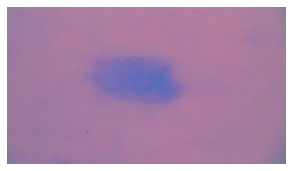

In [16]:
f = get_dicom_files(path_images)[0]
img = PILDicom.create(f)
img.show()

In [18]:
f.dcmread()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7589.1750.1589896848272.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

In [19]:
f.stem

'ISIC_2108457'

## Build DataBlock

Idea: To model test set, split train/val by patient ID.

In [20]:
data = DataBlock()
data.datasets(df_train).train[0]

(image_name                       ISIC_7305142
 patient_id                         IP_7691333
 sex                                    female
 age_approx                                 30
 anatom_site_general_challenge           torso
 diagnosis                             unknown
 benign_malignant                       benign
 target                                      0
 Name: 24062, dtype: object,
 image_name                       ISIC_7305142
 patient_id                         IP_7691333
 sex                                    female
 age_approx                                 30
 anatom_site_general_challenge           torso
 diagnosis                             unknown
 benign_malignant                       benign
 target                                      0
 Name: 24062, dtype: object)

In [22]:
def get_x(r): return path_images/f'{str(r["image_name"])}.dcm'
def get_y(r): return r['benign_malignant']

In [30]:
data = DataBlock(get_x=get_x, get_y=get_y)
data.datasets(df_train).train[0]

(Path('/home/jupyter/data/melanoma-kaggle/train/ISIC_2555494.dcm'), 'benign')

In [24]:
vocab = {'benign': 0, 'malignant': 1}

In [33]:
data = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock(vocab=vocab)),
                get_x=get_x, get_y=get_y)
data.datasets(df_train).train[0]

(PILDicom mode=RGB size=2592x1936, TensorCategory(1))

In [37]:
patient_ids = df_train['patient_id'].unique()
patient_ids.shape, patient_ids[:5]

((2056,),
 array(['IP_7279968', 'IP_3075186', 'IP_2842074', 'IP_6890425',
        'IP_8723313'], dtype=object))

In [45]:
iteration_idxs = np.random.choice(patient_ids, 5, replace=False)
iteration_idxs.shape, iteration_idxs

((5,),
 array(['IP_7180935', 'IP_3858753', 'IP_4788035', 'IP_2545631',
        'IP_6891522'], dtype=object))

In [51]:
%timeit df_train.index[df_train['patient_id'].isin(iteration_idxs)]

1.7 ms ± 7.26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
%timeit np.where(df_train['patient_id'].isin(iteration_idxs))[0]

1.71 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
df_train[df_train['patient_id'].isin(iteration_idxs)].index.values

array([  416,   868,  1169,  1211,  1323,  1344,  1882,  2114,  3447,
        3646,  3982,  4037,  4264,  4549,  5560,  5849,  6383,  7488,
        7556,  8051,  9344, 10439, 11762, 11764, 11769, 12038, 13126,
       13341, 13378, 13399, 13621, 15027, 15272, 15347, 15405, 15440,
       16029, 16082, 16257, 16327, 16352, 16690, 16828, 16897, 17485,
       17748, 17789, 17845, 17920, 18442, 18583, 18697, 19127, 20101,
       20145, 20926, 21294, 21778, 23002, 23170, 23196, 23586, 23627,
       23863, 23930, 24074, 24516, 24578, 25175, 25180, 26274, 26682,
       26878, 26997, 27252, 28485, 28702, 29636, 30325, 30530, 30651,
       30695, 31471, 31588, 31705, 31866, 32340, 32407, 32824])

In [58]:
# split by patient id. Also, allow for creation of smaller iteration set.
def patient_id_splitter(df, iteration_set_num_patients=None, num_train_patients=None, seed=42):
    np.random.seed(seed)
    patient_ids = df_train['patient_id'].unique()
    iteration_set = np.random.choice(patient_ids, iteration_set_num_patients, replace=False)
    return df[df['patient_id'].isin(iteration_set[:num_train_patients])].index.values, df[df['patient_id'].isin(iteration_set[num_train_patients:])].index.values

In [63]:
patient_id_splitter(df_train, 2, 1)

(array([  205,   612,  1703,  2098,  3740,  4317,  4850,  5270,  5315,
         5371,  5862,  6525,  6608,  7089,  8107, 10323, 11603, 11900,
        14066, 14308, 17177, 18963, 20856, 22781, 24502, 25896, 25927,
        27956, 32303]),
 array([ 6908,  7457,  7664,  8003,  8518,  8836,  9061,  9141,  9997,
        10116, 10469, 10630, 12656, 13513, 14041, 14983, 17392, 17873,
        18398, 19558, 20061, 20385, 20597, 20759, 21318, 22079, 24068,
        24835, 25212, 25681, 26943, 27217, 27710, 29825, 29895, 30942,
        31236]))

In [97]:
train_patients, valid_patients = patient_id_splitter(df_train, 100, 20, 6)
df_train.iloc[train_patients]['target'].mean(), df_train.iloc[valid_patients]['target'].mean()

(0.018115942028985508, 0.011226944667201283)

#### Percent of people with malignant mole is 0.01 in entire train data --> Try out different random seeds to get **similar distribution** in iteration set.

In [98]:
data = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock(vocab=vocab)),
                get_x=get_x, get_y=get_y, splitter=partial(patient_id_splitter, iteration_set_num_patients=100, num_train_patients=80))
ds = data.datasets(df_train)

In [99]:
len(ds.train), len(ds.valid)

(1529, 233)

In [100]:
x, y = ds.train[0]
x, y, x.shape, y.shape

(PILDicom mode=RGB size=5184x3456,
 TensorCategory(0),
 (3456, 5184),
 torch.Size([]))

### Define Data Aug/Resizing

In [101]:
proc_data = data.new(item_tfms=Resize(400), batch_tfms=aug_transforms(min_scale=0.8))
ds = proc_data.datasets(df_train)
ds.train[0], len(ds.train), len(ds.valid)

((PILDicom mode=RGB size=5184x3456, TensorCategory(0)), 1529, 233)

## Build Dataloaders

In [102]:
dls = proc_data.dataloaders(df_train)
dls, len(dls.train), len(dls.valid), dls.c

(<fastai.data.core.DataLoaders at 0x7f18a705acd0>, 23, 4, 2)

In [104]:
xb, yb = dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 372, 372]), torch.Size([64]))

## Look at processed data

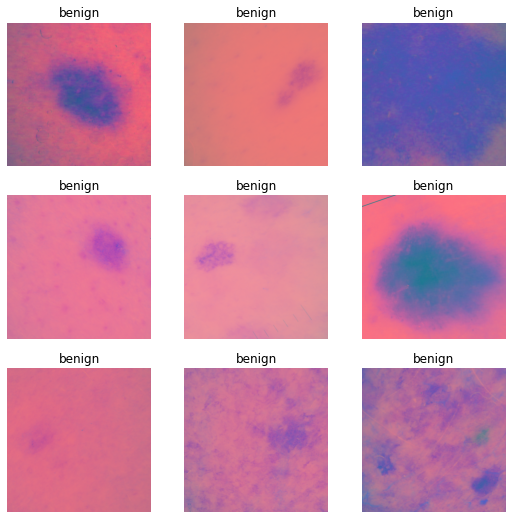

In [105]:
dls.show_batch()

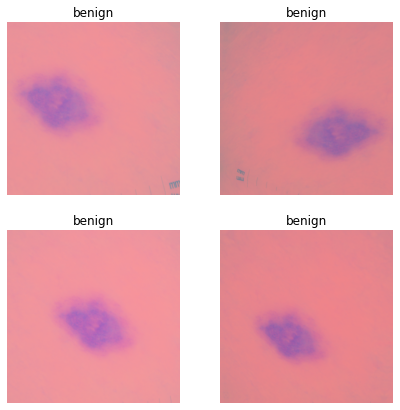

In [106]:
dls.show_batch(max_n=4, figsize=(6, 6), unique=True)

# Modeling

In [ ]:
# wandb.init(project='melanoma-classification')

## Create learner

In [107]:
learn = cnn_learner(dls, resnet18, metrics=RocAucBinary()) #cbs=WandbCallback(log_model=False))

In [108]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Get fine_tune baseline

In [109]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,roc_auc_score,time
0,1.204539,0.653022,0.506448,04:43


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.815203,0.621615,0.518353,04:33
1,0.708827,0.492905,0.703869,04:32
2,0.598279,0.267704,0.572917,04:28
3,0.490850,0.218496,0.648810,04:28
4,0.422062,0.221496,0.655258,04:30


## LR Finder

## Train head

## Unfreeze & Find new LR

## Train entire model w/discriminative LR

# Analysis

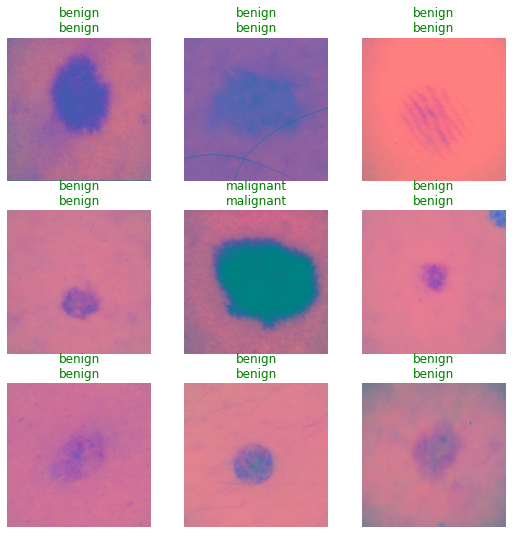

In [110]:
learn.show_results()

In [112]:
interp = ClassificationInterpretation.from_learner(learn)

## Confusion matrix

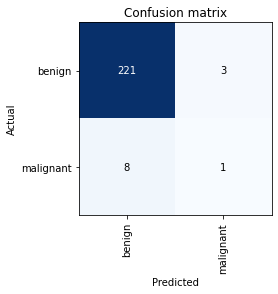

In [113]:
interp.plot_confusion_matrix()

## Top Losses

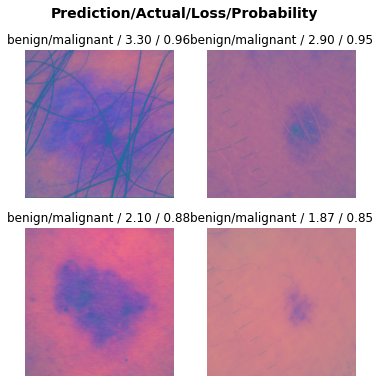

In [116]:
interp.plot_top_losses(k=4)

# Submit

In [119]:
test_dl = dls.test_dl(df_test)

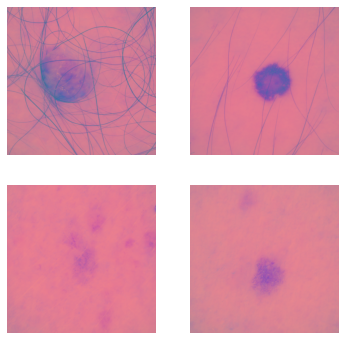

In [121]:
test_dl.show_batch(max_n=4)

## Generate predictions

In [122]:
output = learn.get_preds(dl=test_dl)

In [136]:
output, output[0].shape

((tensor([[0.9030, 0.0970],
          [0.9283, 0.0717],
          [0.8740, 0.1260],
          ...,
          [0.8715, 0.1285],
          [0.7803, 0.2197],
          [0.9313, 0.0687]]),
  None),
 torch.Size([10982, 2]))

In [138]:
preds = output[0].argmax(dim=1)
preds.shape

torch.Size([10982])

In [150]:
preds.nonzero()[:5]

tensor([[ 41],
        [ 56],
        [ 64],
        [110],
        [129]])

<AxesSubplot:>

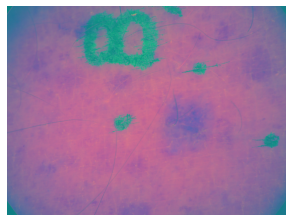

In [153]:
test_dl.dataset[41][0].show()

## Format correctly

In [139]:
(df_test.image_name == ss.image_name).all()

True

In [140]:
submission = pd.read_csv(path/'sample_submission.csv'); submission.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


In [154]:
submission['target'] = preds
submission.describe()

,target
count,10982.000000
mean,0.007649
std,0.087127
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Write to CSV

In [155]:
submission.to_csv('submission.csv', index=False)

## Submit! :)

In [156]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f submission.csv -m "First submssion: end-to-end pipeline works! :)"

100%|████████████████████████████████████████| 161k/161k [00:03<00:00, 54.6kB/s]
Successfully submitted to SIIM-ISIC Melanoma Classification